In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
from models import Net, ConvNet
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

import matplotlib.pyplot as plt

In [66]:
np.random.seed(42)
torch.manual_seed(42)

In [67]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [68]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# we load the body of the neural net trained last time...
model = torch.load('mnist_model.net', map_location='cpu') 

# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), model)

# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

/home/peshal/anaconda3/envs/foolnew/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/peshal/anaconda3/envs/foolnew/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/peshal/anaconda3/envs/foolnew/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrie

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet(
      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2, inplace=False)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum=

In [69]:
# define a show function
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Adversarial, class: " + str(p1.argmax()))
    print("Class\t\tOrig\tAdv")
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))
    plt.show()

In [70]:
def fgsm(model, x, target, eps, targeted=False):
    input_ = x.clone().detach_()
    input_.requires_grad_()
    
    L = nn.CrossEntropyLoss()
    loss = L(model(input_), torch.tensor([target], dtype=torch.long))
    loss.backward()
    model.zero_grad()
    if targeted:
        return input_ - eps * input_.grad.sign()
    else:
        return input_ + eps * input_.grad.sign()

    
def fgsm_targeted(model, x, label, eps):
    
    return fgsm(model, x, label, eps, targeted=True)

def fgsm_untargeted(model, x, label, eps):
    
    return fgsm(model, x, label, eps, targeted=False)

def pgd(model, x, target, k, eps, eps_step, targeted, clip_min=None, clip_max=None):
    x_min = x - eps
    x_max = x + eps
    for i in range(k):
        
        x = fgsm(model, x, target, eps_step, targeted)
        # Project it on the linf eps ball around original sample
        x = torch.max(x_min, x)
        x = torch.min(x_max, x)
    
    if (clip_min is not None) or (clip_max is not None):
        x.clamp_(min=clip_min, max=clip_max)
    return x
        

def pgd_targeted(model, x, target, k, eps, eps_step, **kwargs):
    return pgd(model, x, target, k, eps, eps_step, targeted=True, **kwargs)
    
def pgd_untargeted(model, x, label, k, eps, eps_step, **kwargs):
    return pgd(model, x, label, k, eps, eps_step, targeted=False, **kwargs)

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.91
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	1.00	0.09
Class 8:	0.00	0.00
Class 9:	0.00	0.00


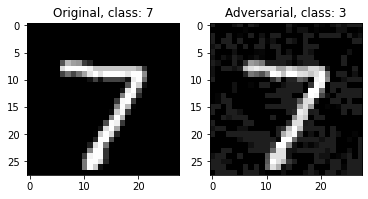

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	1.00	1.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


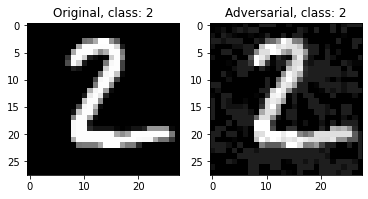

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	1.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	1.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


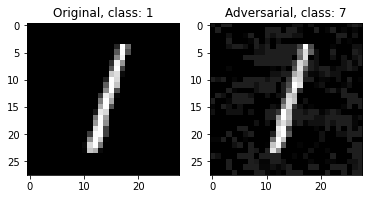

Class		Orig	Adv
Class 0:	1.00	0.94
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.06
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


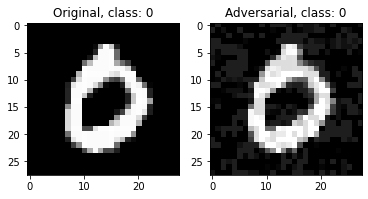

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	1.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	1.00


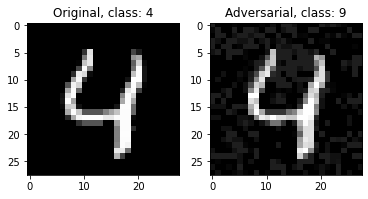

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	1.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	1.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


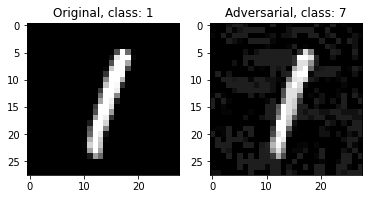

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	1.00	0.19
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.81


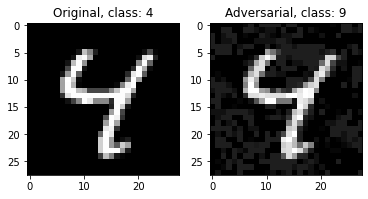

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	1.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	1.00	0.00


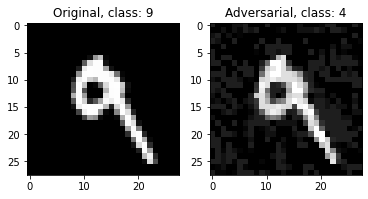

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	1.00	0.00
Class 6:	0.00	1.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


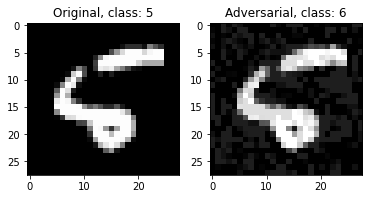

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.02
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.47
Class 8:	0.00	0.00
Class 9:	1.00	0.51


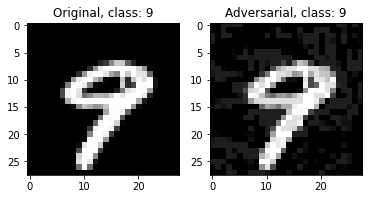

In [71]:
# try out attacks
for i in range(10):
    original_image = torch.unsqueeze(test_dataset[i][0], dim=0)
    original_label = model_to_prob(original_image).detach().numpy().argmax()
    adv = pgd_untargeted(model, original_image, original_label, 50, 0.12, 0.05, clip_min=0, clip_max=1.0)
    show(original_image, adv, model_to_prob)

## Targeted PGD

Class		Orig	Adv
Class 0:	0.00	0.53
Class 1:	1.00	0.34
Class 2:	0.00	0.01
Class 3:	0.00	0.00
Class 4:	0.00	0.12
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.01
Class 9:	0.00	0.00


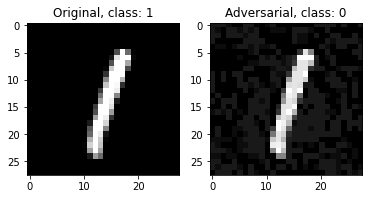

In [15]:
adv = pgd_targeted(model, original_image, 0, 100, 0.1, 0.05, clip_min=0, clip_max=1.0)

show(original_image, adv, model_to_prob)

# CIFAR

In [4]:
from cifar_model import ConvNet1

In [8]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.CIFAR10('cifar_data/', train=False, download=False, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [33]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.5) / 0.5


model = ConvNet1()
# we load the body of the neural net trained last time...
model.load_state_dict(torch.load('cifar_model.pt', map_location='cpu'))

# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), model)

# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet1(
      (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2, inplace=False)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum

In [57]:
# define a show function
def show(original, adv, model_to_prob, classes):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original[0].permute(1, 2, 0).detach().numpy())
    axarr[0].set_title("Original, class: " + classes[p0.argmax()])
    axarr[1].imshow(adv[0].permute(1, 2, 0).detach().numpy())
    axarr[1].set_title("Adversarial, class: " + classes[p1.argmax()])
    print("Class\t\tOrig\tAdv")
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))
    plt.show()

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.01	0.01
Class 3:	0.80	0.07
Class 4:	0.00	0.00
Class 5:	0.12	0.91
Class 6:	0.06	0.00
Class 7:	0.00	0.01
Class 8:	0.00	0.00
Class 9:	0.00	0.00


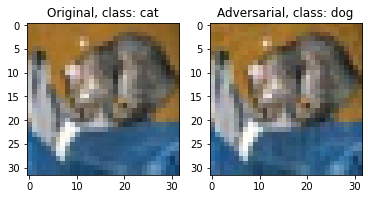

Class		Orig	Adv
Class 0:	0.02	0.00
Class 1:	0.01	0.97
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.97	0.01
Class 9:	0.00	0.01


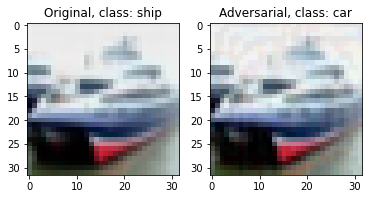

Class		Orig	Adv
Class 0:	0.23	1.00
Class 1:	0.01	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.73	0.00
Class 9:	0.02	0.00


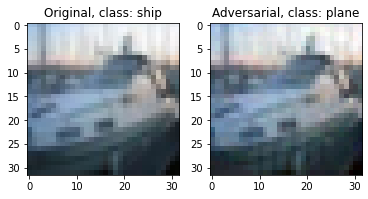

Class		Orig	Adv
Class 0:	0.93	0.03
Class 1:	0.00	0.01
Class 2:	0.01	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.05	0.96
Class 9:	0.00	0.01


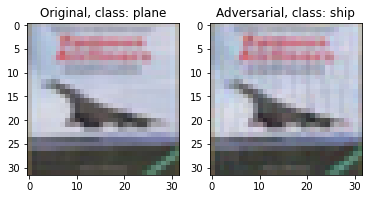

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.04	0.00
Class 3:	0.01	0.00
Class 4:	0.60	0.00
Class 5:	0.00	0.00
Class 6:	0.35	1.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


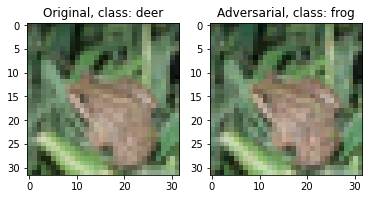

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.01	0.00
Class 3:	0.12	0.06
Class 4:	0.00	0.00
Class 5:	0.04	0.93
Class 6:	0.83	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


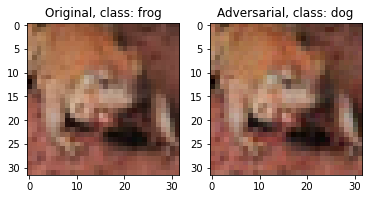

Class		Orig	Adv
Class 0:	0.01	0.01
Class 1:	0.89	0.10
Class 2:	0.01	0.01
Class 3:	0.01	0.02
Class 4:	0.00	0.00
Class 5:	0.00	0.01
Class 6:	0.00	0.00
Class 7:	0.00	0.01
Class 8:	0.00	0.00
Class 9:	0.08	0.84


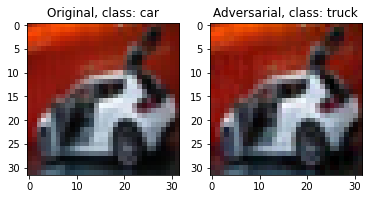

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.08	0.00
Class 3:	0.01	0.00
Class 4:	0.08	1.00
Class 5:	0.00	0.00
Class 6:	0.82	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


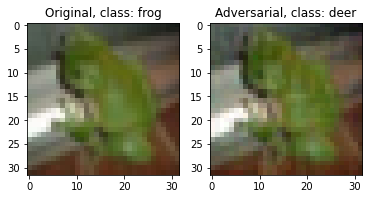

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.05	0.03
Class 3:	0.56	0.03
Class 4:	0.07	0.00
Class 5:	0.29	0.93
Class 6:	0.02	0.00
Class 7:	0.01	0.01
Class 8:	0.00	0.00
Class 9:	0.00	0.00


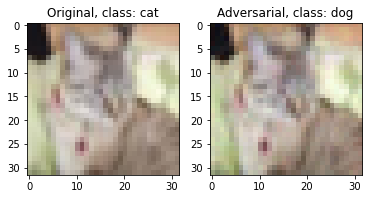

Class		Orig	Adv
Class 0:	0.01	0.00
Class 1:	0.88	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	0.10	0.99


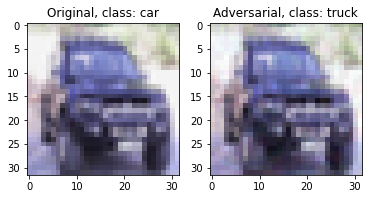

Class		Orig	Adv
Class 0:	0.18	0.98
Class 1:	0.00	0.00
Class 2:	0.04	0.00
Class 3:	0.10	0.00
Class 4:	0.36	0.00
Class 5:	0.19	0.00
Class 6:	0.00	0.00
Class 7:	0.12	0.00
Class 8:	0.00	0.01
Class 9:	0.00	0.00


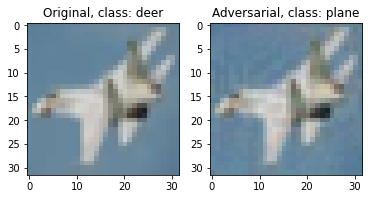

Class		Orig	Adv
Class 0:	0.00	0.01
Class 1:	0.00	0.30
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.00
Class 9:	1.00	0.68


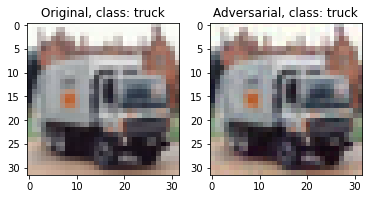

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.02	0.00
Class 3:	0.26	0.00
Class 4:	0.21	0.99
Class 5:	0.49	0.00
Class 6:	0.00	0.00
Class 7:	0.02	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


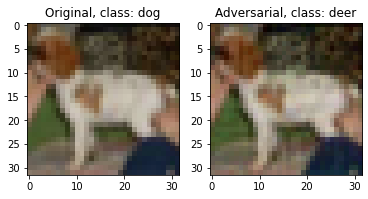

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	0.01
Class 4:	0.00	0.01
Class 5:	0.01	0.16
Class 6:	0.00	0.00
Class 7:	0.99	0.82
Class 8:	0.00	0.00
Class 9:	0.00	0.00


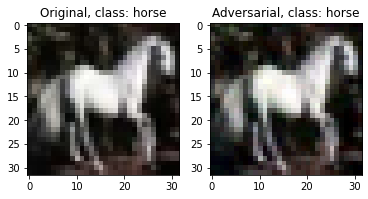

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.01	0.67
Class 2:	0.00	0.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	0.00	0.00
Class 8:	0.00	0.01
Class 9:	0.99	0.32


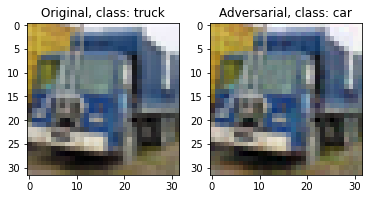

In [61]:
# try out attacks

classes = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(15):
    original_image = torch.unsqueeze(test_dataset[i][0], dim=0)
    original_label = model_to_prob(original_image).detach().numpy().argmax()
    adv = pgd_untargeted(model, original_image, original_label, 10, 0.02, 0.004, clip_min=0, clip_max=1.0)
    # adv = pgd_targeted(model, original, 7, 10, 0.08, 0.05, clip_min=0, clip_max=1.0)
    show(original_image, adv, model_to_prob, classes)